# Project 2
### Logistic Regression of Galaxy Morphological Type Frequencies by Redshift

### 1. Importing Packages and Reading in the Data

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
import math

### 2. Visual Inspection of Data

In [4]:
df = pd.read_csv('GalaxyMorphZ.tsv', sep="\t")
df.head()

,objID,z,SVMPython,RFPython
0,1237657190905217072,0.078133,0,0
1,1237657191978959105,0.082131,0,0
2,1237652944249094158,0.083400,0,0
3,1237656496724312079,0.020017,1,1
4,1237657191978959113,0.082439,0,0


In [5]:
df.describe()

,objID,z,SVMPython,RFPython
count,3.160310e+05,316031.000000,316031.000000,316031.000000
mean,1.237662e+18,0.063504,0.558053,0.581721
std,6.022167e+12,0.023058,0.496619,0.493277
min,1.237646e+18,0.003001,0.000000,0.000000
25%,1.237658e+18,0.045979,0.000000,0.000000
50%,1.237662e+18,0.067202,1.000000,1.000000
75%,1.237665e+18,0.082217,1.000000,1.000000
max,1.237680e+18,0.100000,1.000000,1.000000


Text(0.5, 1.0, 'Proportions According to SVM')

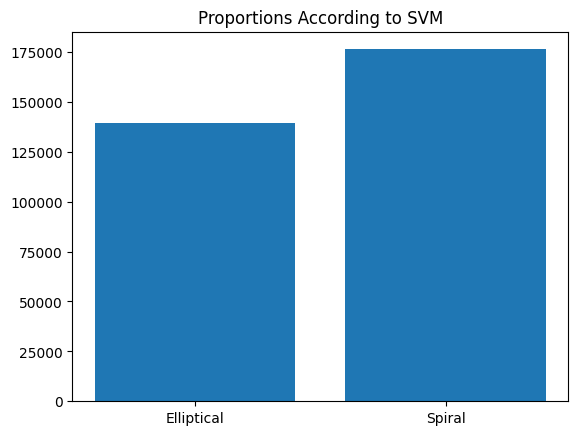

In [6]:
# We will just look at the SVM classifications in this project

N = len(df)

elliptical = df[df['SVMPython']==0]
spiral = df[df['SVMPython']==1]
num_elliptical = len(elliptical)
num_spiral = len(spiral)

plt.bar(['Elliptical','Spiral'],[num_elliptical,num_spiral])
plt.title("Proportions According to SVM")

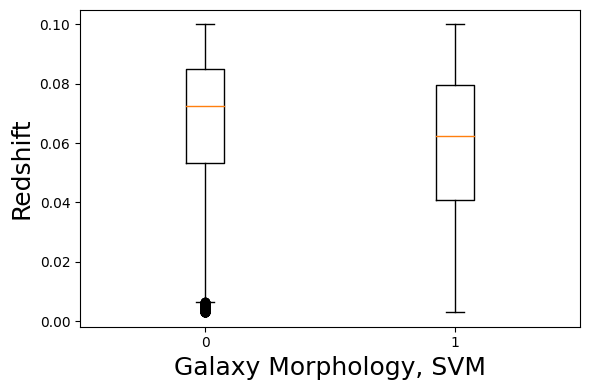

In [7]:
# Boxplot
spirals = df['SVMPython'] == 1

plt.figure(figsize = (6, 4))

plt.boxplot(x = [df['z'][~spirals], df['z'][spirals]], labels = '01');

plt.ylabel('Redshift', fontsize = 18);
plt.xlabel('Galaxy Morphology, SVM', fontsize = 18);


plt.tight_layout()

plt.show()

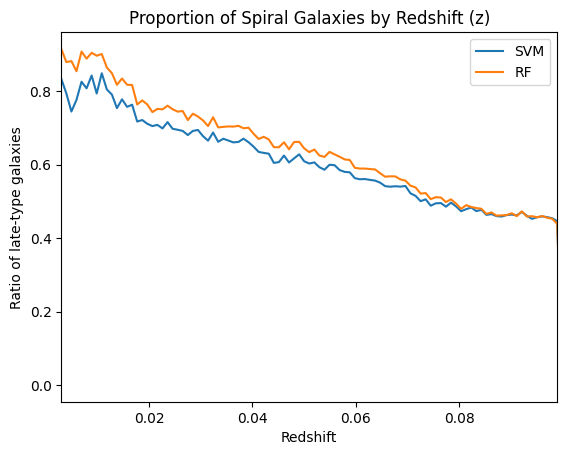

In [8]:
# Plotting proportions of spiral over redshift

x=np.linspace(np.min(df["z"]),np.max(df["z"]),100)
y1=np.zeros(100)
y2=np.zeros(100)
sep=x[1]-x[0]
for i,z in enumerate(x):
    try:
        y1[i]=len(df[(df["SVMPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y1[i]=0
for i,z in enumerate(x):
    try:
        y2[i]=len(df[(df["RFPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y2[i]=0
plt.plot(x,y1,label="SVM")
plt.plot(x,y2,label="RF")
plt.legend()
plt.xlim(x[0],x[-2])
plt.xlabel("Redshift")
plt.ylabel("Ratio of late-type galaxies")
plt.title("Proportion of Spiral Galaxies by Redshift (z)")
plt.show()


### 3. Establishing Priors and Creating Model

In [9]:
#Minimum Effective Sample Size - we have 6: mean, lb and ub for CI for both b0 and b1

import pymc as pm
import arviz as az
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

N_sample = minESS(6).astype(int)

print('Minimum effective size:', N_sample)

Minimum effective size: 8708


In [10]:
# We will use the standard reference prior for our Betas (Normal with tau = 0.01, mu = 0)
y = df['SVMPython']
x = df['z']

# Building the model
with pm.Model() as model:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('obs',theta,observed=y)
   
    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);


/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_32079/3386186254.py:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_32079/3386186254.py:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)


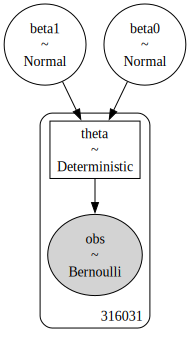

In [11]:
# Visualizing Model
from pymc import Model, Normal, Gamma,model_to_graphviz
model_to_graphviz(model)

In [12]:
# Took about 5 minutes to run this cell

with model:
    #Draw 1000 posterior samples
    idata = pm.sample()
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 162 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### 4. Prior Predictive Check

In [21]:
# To Do

### 5. Posterior Distributions

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

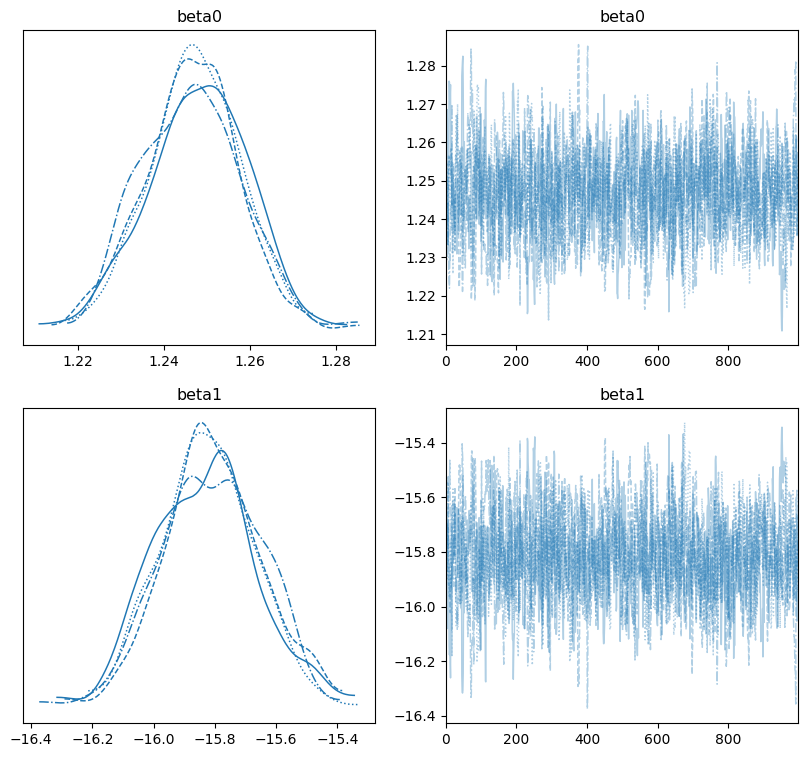

In [14]:
# Posterior Distributions
az.plot_trace(idata,var_names=['beta0','beta1'],figsize=(10, 9)) #Use 'combined=true' to show all chains together

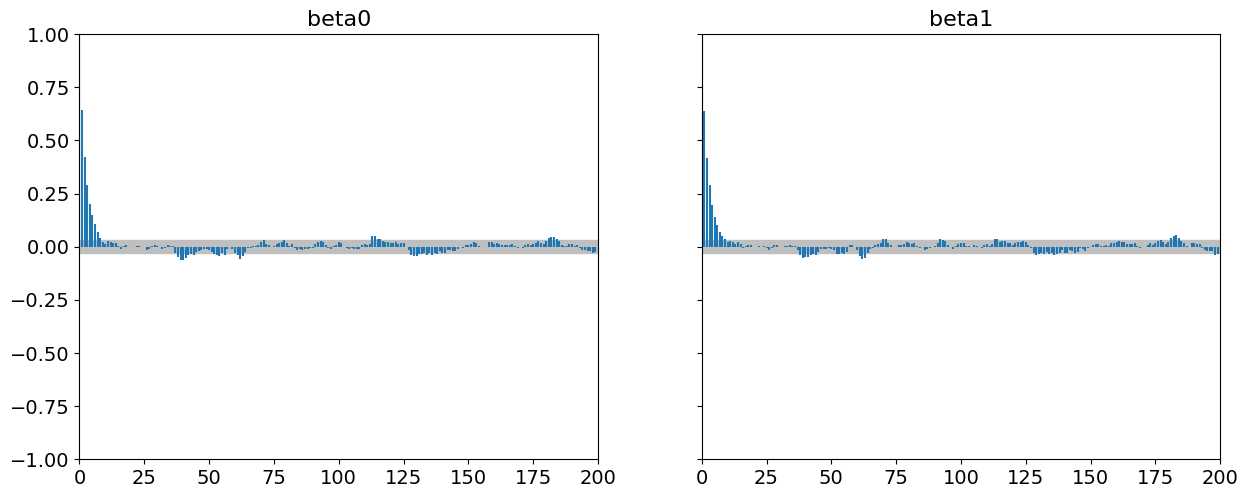

In [15]:
# Auto Correlation Plots
az.plot_autocorr(idata, var_names=['beta0','beta1'],combined=True, max_lag=200);


### 6. Sensitivity Analysis

In [16]:
# To Do

### 7. Posterior Predictive Check

In [17]:
# To Do

### 8. Final Results

In [18]:
# Summary
az.summary(idata, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']]


,mean,hdi_3%,hdi_97%
beta0,1.2470,1.2250,1.2664
beta1,-15.8186,-16.1104,-15.5048


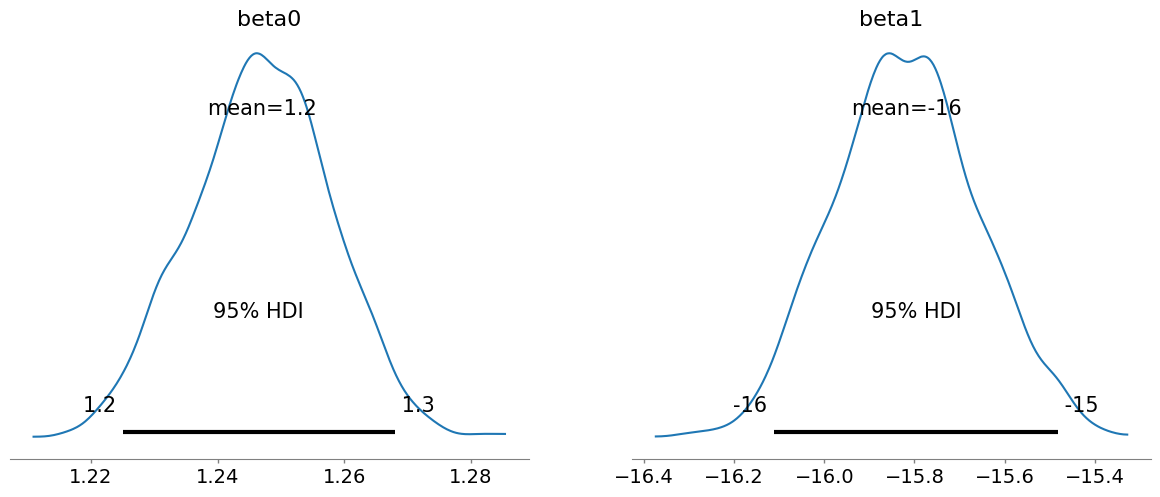

In [19]:
# Posterior Plots with Credible Interval
az.plot_posterior(idata, var_names=['beta0','beta1'], hdi_prob=.95);


<Axes: >

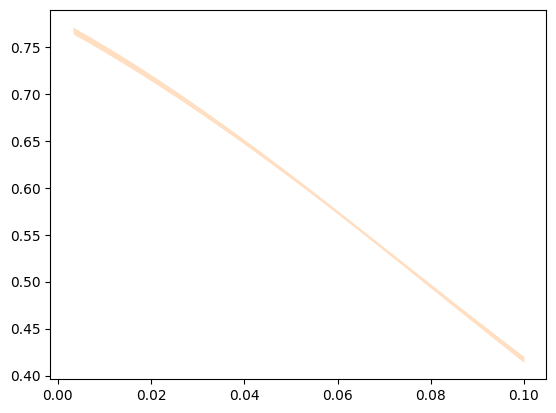

In [20]:
# To Do: Plot original data (maybe some randomly sampled points since we have so many?) and Logistic regression fit line

# Code for Confidence Interval:
az.plot_hdi(x,
    idata.posterior.theta,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    color="C1", plot_kwargs={"label":"95% credibility region"}
)

